# Morphological Transduction with Finite State Transducers

In this notebook, a simple finite state transducer (FST) is implemented, which transduces the infinitive form of Spanish verbs to the preterite (past tense) form in the 3rd person singular (verb conjugation). A [set of Spanish verbs](https://github.com/wjonasreger/data/blob/main/spanish_verbs.csv) are used to evaluate the FST's accuracy.

## Load Packages & Data

In [1]:
import os
import pandas as pd
import random
import sys

random.seed(22)

The Spanish verbs data set contains the following features:
* Verb conjugation rule id (i.e., `rule_id`)
* Verb conjugation rule name (i.e., `rule_name`)
* Infinitive verb forms (i.e., `infinitive`)
* Preterite verb forms in the 3rd person singular case (i.e., `conjugate`)

In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/wjonasreger/data/main/spanish_verbs.csv')

df_sample = pd.DataFrame()
for c in df['rule_id'].unique():
  df_temp = df.iloc[ list(df['rule_id'] == c), :]
  df_sample = pd.concat([df_sample, df_temp.sample(1)], axis=0)

df_sample.set_index('rule_id', inplace=True)
df_sample.sort_index(inplace=True)
df_sample

,rule_name,infinitive,conjugate
rule_id,,,
1,-Car : -Có,descuajar,descuajó
2,-Var : -Vó,zurear,zureó
3,-Cer : -Ció,oscurecer,oscureció
4,-Cir : -Ció,transcribir,transcribió
5,-guir : -guió,extinguir,extinguió
6,-quir : -quió,derelinquir,derelinquió
7,-ñer : -ñó,tañer,tañó
8,-ñir : -ñó,gañir,gañó
9,-Ver : -Vyó,desposeer,desposeyó


## Classes for FST Models

### The `Transition` Class

Every state is linked to another state by a transition. This class defines the following methods for transitions.
* **Initialization** (i.e., `__init__(self, state_in, string_in, string_out, state_out)`): Saves the strings and states for the transition.
* **Equivalence** (i.e., `equals(self, t)`): Compares two transition objects for equivalence.

In [3]:
class Transition:
  def __init__(self, state_in, string_in, string_out, state_out):
    self.state_in = state_in
    self.string_in = string_in
    self.state_out = state_out
    self.string_out = string_out

  def equals(self, t):
    if self.state_in == t.state_in \
    and self.string_in == t.string_in \
    and self.state_out == t.state_out \
    and self.string_out == t.string_out:
      return True
    else:
      return False

### The `State` Class

Each state of the transducer is defined by this class. Here are the methods as shown below.

* **Initialization** (i.e., `__init__(id, is_final, FST)`): Adds state features.
* **Add a transition** (i.e. `addTransition(self, string_in, string_out, state_out)`): Creates a new transition and checks if it already exists. New transitions are added to a transition dictionary, `transitions`.
* **Parse input from start state** (i.e., `parseInputFromStartState(self, string_in, debug=False)`): Generates full text parsing and acceptance of the parse.
* **Parse input** (i.e., `parseInput(self, string_in, debug=False)`): Parse the string input to support parsing the entire word. Two cases are considered, an empty suffix and a non-empty suffix. 
* **Print state** (i.e., `printState(self)`): Prints the state attributes.

In [4]:
class State:
  def __init__(self, id, is_final, FST):
    self.id = id  # integer id of the state
    self.is_final = is_final  # indicator that this is the final state
    self.transitions = dict() # map string_in to a set of all possible transitions
    self.FST = FST

  def addTransition(self, string_in, string_out, state_out):
    # create new transition
    new_transition = Transition(self, string_in, string_out, state_out)
    if string_in in self.transitions:
      for t in self.transitions[string_in]:
        if t.equals(new_transition):
          return
      self.transitions[string_in].add(new_transition)
    else:
      self.transitions[string_in] = set([])
      self.transitions[string_in].add(new_transition)
  
  def parseInputFromStartState(self, string_in, debug=False):
    parse_tuple = ("", self.id)
    parses = []
    (accept, string_parses) = self.parseInput(string_in, debug)
    if accept:
      for p in string_parses:
        complete_parse = [parse_tuple]
        complete_parse.extend(p)
        parses.append(complete_parse)
    return (accept, parses)

  def parseInput(self, string_in, debug=False):
      parses = []
      if debug:
        print("parseInput: state: ", self.id, " parsing: " , string_in)
      
      # case 1: no suffix
      if string_in == "":
        epsilon_parses = []
        epsilon_accepted = False
        # try all epsilon transitions
        if "" in self.transitions:
          trans_set = self.transitions[""]
          for t in trans_set:
            string_out = t.string_out
            to_state_id = t.state_out
            to_state = self.FST.all_states[to_state_id]
            parse_tuple = (string_out, to_state_id)
            (suffix_accepted, suffix_parses) = to_state.parseInput(string_in)
            if suffix_accepted:
              epsilon_accepted = True
              if suffix_parses == []: # accepts
                parse_s = [parse_tuple]
                epsilon_parses.append(parse_s)
              else:
                for s in suffix_parses:
                  parse_s = [parse_tuple]
                  parse_s.extend(s)
                  epsilon_parses.append(parse_s)
        # if epsilon is accepted, add all its parses
        if epsilon_accepted:
          parses.extend(epsilon_parses)
        # if this is a final state, add an empty parse
        if self.is_final or parses != []:
          if debug:
            print("Accepted in state ", self.id)
          return (True, parses)
        else:
          if debug:
            print("Rejected in state ", self.id)
          return (False, None)

      # case 2: non-empty suffix - there needs to be one suffix that parses
      has_accepted_suffix = False;
      for i in range(0,len(string_in)+1):
        prefix = string_in[0:i]
        suffix = string_in[i:len(string_in)]
        if debug:
          print("\t prefix: \'", prefix, "\' I=", i)
        if prefix in self.transitions:
          if debug:
            print("\t prefix: ", prefix,  "suffix: ", suffix, "I=", i)
          trans_set = self.transitions[prefix]
          for t in trans_set:
            string_out = t.string_out
            to_state_id = t.state_out
            to_state = self.FST.all_states[to_state_id]
            parse_tuple = (string_out, to_state_id)
            (suffix_accepted, suffix_parses) = to_state.parseInput(suffix)
            if suffix_accepted:
              has_accepted_suffix = True
              if suffix_parses == []:
                parse_s = [parse_tuple]
                parses.append(parse_s)
                this_prefix_parses = True
              for s in suffix_parses:
                parse_s = [parse_tuple]
                parse_s.extend(s)
                parses.append(parse_s)

      if has_accepted_suffix:
        return (True, parses)
      else:
        return (False, None)
                          
  def printState(self):
    if self.is_final:
      FINAL = "FINAL"
    else: FINAL = ""
    print("State", self.id, FINAL)
    for string_in in self.transitions:
      trans_list = self.transitions[string_in]
      for t in trans_list:
        print("\t", string_in, ":", t.string_out, " => ", t.state_out)

### The `FST` Class

Here, the FST class is defined with methods to conveniently construct an FST model.

* **Initialization** (i.e., `__init__(self, init_state_name="INIT")`): Initializes an FST object with an initial (non-accepting) state named `init_state_name`)
* **Add a state** (i.e., `addState(self, name, is_final=False)`): Adds a state `name` to the FST. A state is not an accepting state by default.

* **Add a transition** (i.e., `addTransition(self, state_in_name, string_in, string_out, state_out_name)`): Add a transition from state `state_in_name` to state `state_out_name`, where both states already exist in the FST. The FST can traverse this transition after reading `string_in`, and outputs `string_out` when it does so. Essentially, this maps an input string `string_in` to an output string `string_out`.

* **Add a self transition** (i.e., `addSelfTransition(self, state_in_name, string_in, state_out_name)`): Maps an input string to itself, between the input and output states.
* **Add an epsilon transition** (i.e., `addEpsilonTransition(self, state_in_name, state_out_name)`): Maps an empty string to itself, between the input and output states.

* **Add a set transition** (i.e., `addSetTransition(self, state_in_name, string_in_set, state_out_name)`): Maps every element in an input set to itself, between the input and output states.
* **Add a set to string transition** (i.e., `addSetToStringTransition(self, state_in_name, string_in_set, string_out, state_out_name)`): Maps every element in an input set to an output string, between the input and output states.
* **Add a set to epsilon transition** (i.e., `addSetToEpsilonTransition(self, state_in_name, string_in_set, state_out_name)`): Maps every element in an input set to an empty string, between the input and output states.

* **Add a dictionary transition** (i.e., `addDictTransition(self, state_in_name, string_in_dict, state_out_name)`): Maps every key to its value in an input dictionary, between the input and output states.

* **Parse input** (i.e., `parseInput(self, string_in, show_states=False, debug=False)`): Parses a single string input.
* **Parse input lists** (i.e., `parseInputList(self, verb_list, show_states=False, debug=False)`): Parse all input strings.

* **Print the FST** (i.e., `printFST(self)`): Prints FST details.

In [5]:
class FST:
  def __init__(self, init_state_name="INIT"):
    self.n_states = 0
    self.init_state = State(init_state_name, False, self) 
    self.all_states = dict()
    self.all_states[init_state_name] = self.init_state
      
  def addState(self, name, is_final=False):
    if name in self.all_states:
      print("ERROR addState: state", name, "exists already")
      sys.exit()
    else:  
      new_state = State(name, is_final, self)
      self.all_states[name] = new_state

  def addTransition(self, state_in_name, string_in, string_out, state_out_name):
    if (len(string_in) > 1):
      print("ERROR: addTransition: input string ", string_in, " is longer than one character")
      sys.exit()
    if state_in_name not in self.all_states:
      print("ERROR: addTransition: state ", state_in_name, " does not exist")
      sys.exit()
    if state_out_name not in self.all_states:
      print("ERROR: addTransition: state ", state_out_name, " does not exist")
      sys.exit()
    state_in = self.all_states[state_in_name]
    state_in.addTransition(string_in, string_out, state_out_name)

  # map string to itself
  def addSelfTransition(self, state_in_name, string_in, state_out_name):
    if state_in_name not in self.all_states:
      print("ERROR: addSetTransition: state ", state_in_name, " does not exist")
      sys.exit()
    if state_out_name not in self.all_states:
      print("ERROR: addSetTransition: state ", state_out_name, " does not exist")
      sys.exit()
    self.addTransition(state_in_name, string_in, string_in, state_out_name)

  # epsilon:epsilon
  def addEpsilonTransition(self, state_in_name, state_out_name):
    if state_in_name not in self.all_states:
      print("ERROR: addEpsilonTransition: state ", state_in_name, " does not exist")
      sys.exit()
    if state_out_name not in self.all_states:
      print("ERROR: addEpsilonTransition: state ", state_out_name, " does not exist")
      sys.exit()
    if state_in_name == state_out_name:
      print("ERROR: epsilon loop")
      sys.exit()
    state_in = self.all_states[state_in_name]
    state_in.addTransition("", "", state_out_name)

  # map every element in string_in_set to itself
  def addSetTransition(self, state_in_name, string_in_set, state_out_name):
    if state_in_name not in self.all_states:
      print("ERROR: addSetTransition: state ", state_in_name, " does not exist")
      sys.exit()
    if state_out_name not in self.all_states:
      print("ERROR: addSetTransition: state ", state_out_name, " does not exist")
      sys.exit()
    for s in string_in_set:
      self.addTransition(state_in_name, s, s, state_out_name)

  # map every element in string_in_set to string_out
  def addSetToStringTransition(self, state_in_name, string_in_set, string_out, state_out_name):
    if state_in_name not in self.all_states:
      print("ERROR: addSetDummyTransition: state ", state_in_name, " does not exist")
      sys.exit()
    if state_out_name not in self.all_states:
      print("ERROR: addSetDummyTransition: state ", state_out_name, " does not exist")
      sys.exit()
    for s in string_in_set:
      self.addTransition(state_in_name, s, string_out, state_out_name)
  
  # map every element in string_in_set to string_out=""
  def addSetToEpsilonTransition(self, state_in_name, string_in_set, state_out_name):
    if state_in_name not in self.all_states:
      print("ERROR: addSetEpsilonTransition: state ", state_in_name, " does not exist")
      sys.exit()
    if state_out_name not in self.all_states:
      print("ERROR: addSetEpsionTransition: state ", state_out_name, " does not exist")
      sys.exit()
    for s in string_in_set:
      self.addTransition(state_in_name, s, "", state_out_name)

  # map every key element in string_in_dict to its value
  def addDictTransition(self, state_in_name, string_in_dict, state_out_name):
    if state_in_name not in self.all_states:
      print("ERROR: addSetTransition: state ", state_in_name, " does not exist")
      sys.exit()
    if state_out_name not in self.all_states:
      print("ERROR: addSetTransition: state ", state_out_name, " does not exist")
      sys.exit()
    for key, value in string_in_dict.items():
      self.addTransition(state_in_name, key, value, state_out_name)
          
  def parseInput(self, string_in, show_states=False, debug=False):
    string_in = string_in.rstrip('\n')
    (can_parse, all_parses)  = self.init_state.parseInputFromStartState(string_in, debug)
    all_parses_as_string = ""
    if can_parse:
      for parse in all_parses:
        for tuple in parse:
          string_out, state_out = tuple
          all_parses_as_string += string_out
        if show_states:
          all_parses_as_string += "\t  States: "
          i = 0
          for tuple in parse:
            i += 1
            string_out, state_out = tuple
            all_parses_as_string += state_out
            if i < len(parse):
              all_parses_as_string += " => "
          all_parses_as_string += "; "
  
      return True, all_parses_as_string
    else:
      return False, "FAIL"

  def parseInputList(self, verb_list, show_states=False, debug=False):
    n_parses = 0
    total_strings = 0
    res = []
    for verb in verb_list:
      total_strings += 1
      can_parse, parse = self.parseInput(verb, show_states, debug)
      res += [parse]
      if can_parse:
        n_parses += 1
    fraction = n_parses / total_strings
    print(n_parses, "/", total_strings, "=", str(fraction * 100)+'%', "of examples parsed") 
    return res

  def printFST(self):
    print("Printing FST", str(self))
    for state_id in self.all_states:
      state = self.all_states[state_id]
      state.printState()

## Building the FST

Here is an FST structure template and function to build FST models.

In [6]:
'''
structure = {
    '_init': 'INIT', # the initial state
    '_accept': 'EOW', # an accepting state
    '_states': ['EPS'],
    '_transitions': {
        '_regular': 
          [{'state_in_name':'', 'string_in':'', 'string_out':'', 'state_out_name':''}],
        '_self': 
          [{'state_in_name':'', 'string_in':'', 'state_out_name':''}],
        '_epsilon': 
          [{'state_in_name':'', 'state_out_name':''}],
        '_set': 
          [{'state_in_name':'', 'string_in_set':'', 'state_out_name':''}],
        '_set2string': 
          [{'state_in_name':'', 'string_in_set':'', 'string_out':'', 'state_out_name':''}]],
        '_set2epsilon': 
          [{'state_in_name':'', 'string_in_set':'', 'state_out_name':''}],
        '_dict': 
          [{'state_in_name':'', 'string_in_dict':'', 'state_out_name':''}]
    }
}
'''

def buildFST(structure):
  # instantiate FST
  f = FST(init_state_name=structure['_init'])
  # add accepting state
  f.addState(name=structure['_accept'], is_final=True)
  # add all states
  for s in structure['_states']:
    f.addState(name=s)
  # add regular transitions
  if structure['_transitions']['_regular'] is not None:
    for t in structure['_transitions']['_regular']:
      f.addTransition(t['state_in_name'], t['string_in'], t['string_out'], t['state_out_name'])
  # add self transitions
  if structure['_transitions']['_self'] is not None:
    for t in structure['_transitions']['_self']:
      f.addSelfTransition(t['state_in_name'], t['string_in'], t['state_out_name'])
  # add epsilon transitions
  if structure['_transitions']['_epsilon'] is not None:
    for t in structure['_transitions']['_epsilon']:
      f.addEpsilonTransition(t['state_in_name'], t['state_out_name'])
  # add set transitions
  if structure['_transitions']['_set'] is not None:
    for t in structure['_transitions']['_set']:
      f.addSetTransition(t['state_in_name'], t['string_in_set'], t['state_out_name'])
  # add set to string transitions
  if structure['_transitions']['_set2string'] is not None:
    for t in structure['_transitions']['_set2string']:
      f.addSetToStringTransition(t['state_in_name'], t['string_in_set'], t['string_out'], t['state_out_name'])
  # add set to epsilon transitions
  if structure['_transitions']['_set2epsilon'] is not None:
    for t in structure['_transitions']['_set2epsilon']:
      f.addSetToEpsilonTransition(t['state_in_name'], t['string_in_set'], t['state_out_name'])
  # add dictionary transitions
  if structure['_transitions']['_dict'] is not None:
    for t in structure['_transitions']['_dict']:
      f.addDictTransition(t['state_in_name'], t['string_in_dict'], t['state_out_name'])
  return f

### Counting Consonants Transduction

Here is a simple FST that maps each consonant to <TT>I</TT> and each vowel to an empty string. All words with no unknown characters will be accepted by the FST. First, consider the graph for this FST, then the code. This FST is essentially a tally system to count how many consonants are in a word.

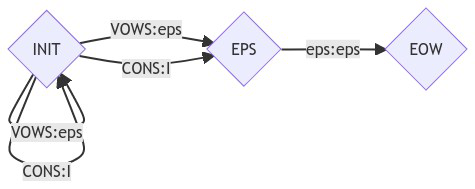

In [7]:
%matplotlib inline

import base64
import requests, io
from PIL import Image
import matplotlib.pyplot as plt

graph = """
flowchart LR
    %% initial state
    INIT{INIT} --"VOWS:eps"--> INIT
    INIT --"CONS:I"--> INIT

    %% epsilon state
    INIT --"VOWS:eps"--> EPS{EPS}
    INIT --"CONS:I"--> EPS

    %% accepting state
    EPS --"eps:eps"--> EOW{EOW}
"""

graphbytes = graph.encode("utf-8")
base64_bytes = base64.b64encode(graphbytes)
base64_string = base64_bytes.decode("utf-8")
background_color = '?bgColor=!white'
requested_content = requests.get('https://mermaid.ink/img/' + base64_string + background_color).content
image = Image.open(io.BytesIO(requested_content))
image

Here is the FST structure as a dictionary. This can be processed by the `buildFST(structure)` function to build the FST model given a structure.

In [8]:
A2Z = set('abcdefghijklmnopqrstuvwxyz')
VOWS = set('aeiou')
CONS = A2Z-VOWS

cons_count_structure = {
    '_init': 'INIT', # the initial state
    '_accept': 'EOW', # an accepting state
    '_states': ['EPS'],
    '_transitions': {
        '_regular': None,
        '_self': None,
        '_epsilon': [
            # If see empty string, then end of word
            {'state_in_name':'EPS', 'state_out_name':'EOW'}
        ],
        '_set': None,
        '_set2string': [
            # # maps consonants to 'I'
            {'state_in_name':'INIT', 'string_in_set':CONS, 'string_out':'I', 'state_out_name':'INIT'},
            {'state_in_name':'INIT', 'string_in_set':CONS, 'string_out':'I', 'state_out_name':'EPS'}
        ],
        '_set2epsilon': [
            # maps vowels to ''
            {'state_in_name':'INIT', 'string_in_set':VOWS, 'state_out_name':'INIT'},
            {'state_in_name':'INIT', 'string_in_set':VOWS, 'state_out_name':'EPS'}
        ],
        '_dict': None
    }
}

In [9]:
# FST for consonant counts
cons_count_fst = buildFST(cons_count_structure)

# example of debugging results for parsing the word "soccer"
fst_parses = cons_count_fst.parseInputList(['soccer'], show_states=True, debug=True)

parseInput: state:  INIT  parsing:  soccer
	 prefix: '  ' I= 0
	 prefix: ' s ' I= 1
	 prefix:  s suffix:  occer I= 1
	 prefix: ' so ' I= 2
	 prefix: ' soc ' I= 3
	 prefix: ' socc ' I= 4
	 prefix: ' socce ' I= 5
	 prefix: ' soccer ' I= 6
1 / 1 = 100.0% of examples parsed


In [10]:
# input word list
sentence = ['the', 'quick', 'brown', 'fox', 'jumps', 'over', 'the', 'lazy', 'dog']

# parse results and the state paths
fst_parses = cons_count_fst.parseInputList(sentence, show_states=True, debug=False)

df_parses = pd.DataFrame({'words':sentence, 'parsings':fst_parses})
df_parses['results'] = df_parses.parsings.apply(lambda x: x.split('\t ')[0])
df_parses['states'] = df_parses.parsings.apply(lambda x: x.split('\t ')[1])
df_parses.drop(['states', 'parsings'], axis=1, inplace=True)
df_parses.set_index('words', inplace=True)
df_parses.T

9 / 9 = 100.0% of examples parsed


words,the,quick,brown,fox,jumps,over,the,lazy,dog
results,II,III,IIII,II,IIII,II,II,III,II


### Spanish Past Tense Transduction

This section will show a rudimentary implementation for transducing verbs to their past tense forms $-$ thus, as it is a simple FST, it is only compatible with regular verbs. Further down, an FST is built to handle conjugations for all verbs in the imported data set.

The FST will parse a string and analyze it after reading the last character. If the string is accepted, then the FST will return the transduced form; if it is not accepted, then the FST will fail the string. The FST is non-deterministic, but each accepted string will only have one analysis or path. If an accepted string had more than one path in the FST, then all paths would be returned and the conjugation would be incorrect. For instance, <TT>hablar ==> hablóhablóhablóhabló</TT>. An input string will be accepted if it reaches a final state after the FST reads its last character.

---

Here are the specifications for producing the 3rd person singular of the Spanish preterite tense from the verb infinitive. An assumption for the transducer is all Spanish infinitives consists of a _stem_ and _ending_, which is always <TT>-ar</TT>, <TT>-er</TT> or <TT>-ir</TT>. For instance, the stem of the verb <TT>hablar</TT> is <TT>habl-</TT> and the ending is <TT>-ar</TT>. The FST handles conjugations of regular verbs and a few exception cases.

1. Verbs ending in <TT>-ar</TT> have <TT>-ó</TT> endings.
2. Verbs ending in <TT>-er</TT> and <TT>-ir</TT> have <TT>-ió</TT> endings.
3. Verbs ending in <TT>-er</TT> or <TT>-ir</TT> with stems that end with an <TT>-ñ</TT> have <TT>-ó</TT> endings.
4. Verbs ending in <TT>-er</TT> or <TT>-ir</TT> with stems that end with a vowel have <TT>-yó</TT> endings. This does not apply to regular verbs ending in <TT>-guir</TT> or <TT>-quir</TT>.
5. Verbs ending in <TT>-ir</TT> with stems that end with an <TT>e</TT> followed by any number of consonants will raise the <TT>e</TT> to an <TT>i</TT> and have <TT>-ió</TT> endings. This does apply to verbs with an <TT>-eguir</TT> ending.

The conjugation rules are shown more specifically in the table below. Note that <TT>C</TT>=Consonant, <TT>S</TT>=String, and <TT>V</TT>=Vowel.

| Rule ID  	| Rule Name              	| Ending  	| Infinitive           	| Conjugation          	| Example                   	|
|-----	|--------------------	|---------	|----------------------	|----------------------	|---------------------------	|
| 01 	| Regular            	| -Car    	| stem + ar            	| stem + ó             	| hablar ==> habló          	|
| 02 	| Regular            	| -Var    	| stem + ar            	| stem + ó             	| pasear ==> paseó          	|
| 03 	| Regular            	| -Cer     	| stem + er            	| stem + ió            	| comer ==> comió           	|
| 04 	| Regular            	| -Cir     	| stem + ir            	| stem + ió            	| abrir ==> abrió           	|
| 05 	| Regular            	| -guir   	| stem + guir          	| stem + guió          	| distinguir ==> distinguió 	|
| 06 	| Regular            	| -quir   	| stem + quir          	| stem + quió          	| delinquir ==> delinquió   	|
| 07  	| ñ-ending Stems     	| -ñer    	| stem(S, ñ) + er      	| stem(S, ñ) + ó       	| tañer ==> tañó            	|
| 08  	| ñ-ending Stems     	| -ñir    	| stem(S, ñ) + ir      	| stem(S, ñ) + ó       	| gruñir ==> gruñó          	|
| 09  	| Vowel-ending Stems 	| -Ver    	| stem(S, V) + er  	| stem(S, V) + yó  	| leer ==> leyó             	|
| 10  	| Vowel-ending Stems 	| -Vir    	| stem(S, V) + ir  	| stem(S, V) + yó  	| construir ==> construyó   	|
| 11  	| Vowel Raising      	| -eCir   	| stem(S, e, C) + ir   	| stem(S, i, C) + ió   	| pedir ==> pidió           	|
| 12  	| Vowel Raising      	| -eCCir  	| stem(S, e, CC) + ir  	| stem(S, i, CC) + ió  	| sentir ==> sintió         	|
| 13  	| Vowel Raising      	| -eCCCir 	| stem(S, e, CCC) + ir 	| stem(S, i, CCC) + ió 	| henchir ==> hinchió       	|
| 14  	| Vowel Raising      	| -eguir  	| stem + eguir         	| stem + iguió         	| seguir ==> siguió         	|
| 15  	| Vowel Raising      	| -eñir   	| stem(S, e, ñ) + ir   	| stem(S, i, ñ) + ó    	| heñir ==> hiñó            	|

This graph outlines the design of the FST for this Spanish verb conjugation task. 

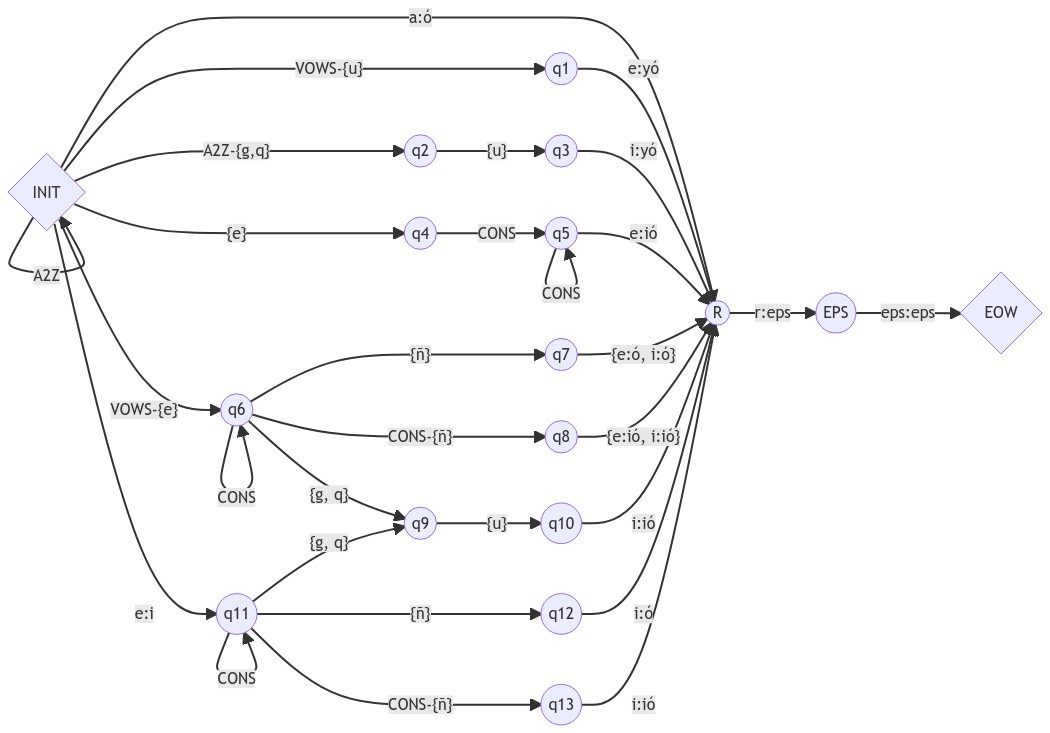

In [11]:
%matplotlib inline

import base64
import requests, io
from PIL import Image
import matplotlib.pyplot as plt

graph = """
flowchart LR
    %% Initial state
    q0{INIT} --A2Z--> q0
    %% Accepting states
    R((R)) --"r:eps"--> EPS((EPS))
    EPS --"eps:eps"--> EOW{EOW}

    %% -Var verbs
    q0 --a:ó--> R

    %% -Ver verbs
    q0 --"VOWS-{u}"--> q1((q1))
    q1 --"e:yó"--> R

    %% -Vir verbs
    q0 --"A2Z-{g,q}"--> q2((q2))
    q2 --"{u}"--> q3((q3))
    q3 --"i:yó"--> R
    
    %% -Cer (includes ñ for "e" verbs)
    q0 --"{e}"--> q4((q4))
    q4 --"CONS"--> q5((q5))
    q5 --"CONS"--> q5
    q5 --"e:ió"--> R

    %% -Cer, -Cir verbs
    q0 --"VOWS-{e}"--> q6((q6))
    q6 --"CONS"--> q6
    q6 --"{ñ}"--> q7((q7))
    q7 --"{e:ó, i:ó}"--> R %% -ñer, -ñir verbs
    q6 --"CONS-{ñ}"--> q8((q8))
    q8 --"{e:ió, i:ió}"--> R %% -Cer, -Cir verbs (excludes ñ)
    q6 --"{g, q}"--> q9((q9))
    q9 --"{u}"--> q10((q10))
    q10((q10)) --"i:ió"--> R %% -guir, -quir verbs (also -eguir verbs from state q11)

    %% eXir verbs
    q0 --e:i--> q11((q11))
    q11 --"CONS"--> q11
    q11 --"{ñ}"--> q12((q12))
    q12 --"i:ó"--> R %% -eñir verbs
    q11 --"CONS-{ñ}"--> q13((q13))
    q13 --"i:ió"--> R %% -eCir, -eCCir, -eCCCir verbs
    q11 --"{g, q}"--> q9

"""

graphbytes = graph.encode("utf-8")
base64_bytes = base64.b64encode(graphbytes)
base64_string = base64_bytes.decode("utf-8")
background_color = '?bgColor=!white'
requested_content = requests.get('https://mermaid.ink/img/' + base64_string + background_color).content
image = Image.open(io.BytesIO(requested_content))
image

Here is the code to implement this Spanish verb conjugation FST model using the structure `spanish_structure`, and FST build function `buildFST(structure)`.

In [12]:
A2Z = set('abcçdefghijklmnopqrstuvwxyzáéíóúñü')
VOWS = set('aeiouáéíóúü')
CONS = A2Z-VOWS

spanish_structure = {
    '_init': 'INIT', # the initial state
    '_accept': 'EOW', # an accepting state
    '_states': ['EPS', 'R', 'q1', 'q2', 'q3', 'q4', 'q5', 'q6', 'q7', 'q8', 'q9', 'q10', 'q11', 'q12', 'q13'],
    '_transitions': {
        '_regular': [
            # Transition on final r in infinitive - replace with empty string
            {'state_in_name':'R', 'string_in':'r', 'string_out':'', 'state_out_name':'EPS'},
            # -Var verbs
            {'state_in_name':'INIT', 'string_in':'a', 'string_out':'ó', 'state_out_name':'R'},
            # -Ver verbs
            {'state_in_name':'q1', 'string_in':'e', 'string_out':'yó', 'state_out_name':'R'},
            # -Vir verbs
            {'state_in_name':'q3', 'string_in':'i', 'string_out':'yó', 'state_out_name':'R'},
            # -Cer verbs (includes ñ)
            {'state_in_name':'q5', 'string_in':'e', 'string_out':'ió', 'state_out_name':'R'},
            # -guir, -quir verbs (also -eguir verbs from state q11)
            {'state_in_name':'q10', 'string_in':'i', 'string_out':'ió', 'state_out_name':'R'},
            # vowel raising 'e' to 'i'
            {'state_in_name':'INIT', 'string_in':'e', 'string_out':'i', 'state_out_name':'q11'},
            # -eñir verbs
            {'state_in_name':'q12', 'string_in':'i', 'string_out':'ó', 'state_out_name':'R'},
            # -eCir, -eCCir, -eCCCir verbs
            {'state_in_name':'q13', 'string_in':'i', 'string_out':'ió', 'state_out_name':'R'}
        ],
        '_self': [
            # e.g., compare: construir ==> construyó, delinguir ==> delinquió
            {'state_in_name':'q2', 'string_in':'u', 'state_out_name':'q3'},
            # e.g., prevents: trascender ==> trascindió (correct: trascendió)
            {'state_in_name':'INIT', 'string_in':'e', 'state_out_name':'q4'},
            # e.g., prevents: tañer ==> tañió (correct: tañó)
            {'state_in_name':'q6', 'string_in':'ñ', 'state_out_name':'q7'},
            # e.g., prevents: seguir ==> siguyó (correct: siguió)
            {'state_in_name':'q9', 'string_in':'u', 'state_out_name':'q10'},
            # e.g., prevents: heñir ==> hiñió (correct: hiñó)
            {'state_in_name':'q11', 'string_in':'ñ', 'state_out_name':'q12'}
        ],
        '_epsilon': [
            # If see empty string, then end of word
            {'state_in_name':'EPS', 'state_out_name':'EOW'}
        ],
        '_set': [
            # self-loop on all letters to transition through stem
            {'state_in_name':'INIT', 'string_in_set':A2Z, 'state_out_name':'INIT'}, # u?
            # check for stems ending with vowel for -er verbs. e.g., leer ==> leyó
            {'state_in_name':'INIT', 'string_in_set':VOWS-{'u'}, 'state_out_name':'q1'}, # u?
            # check for stems ending with vowel for -ir verbs (excluding -guir, -quir verbs)
            # e.g., construir ==> construyó
            {'state_in_name':'INIT', 'string_in_set':A2Z-{'g', 'q'}, 'state_out_name':'q2'},
            # requires consonant between 'e' in stem and -er ending (no vowels in between).
            # e.g., compare: temer ==> temió, leer ==> leyó
            # prevents: leer ==> leió (correct: leyó)
            {'state_in_name':'q4', 'string_in_set':CONS, 'state_out_name':'q5'},
            # allows additional consonants between 'e' in stem and -er ending (no vowels in between).
            # e.g., converger ==> convergió
            {'state_in_name':'q5', 'string_in_set':CONS, 'state_out_name':'q5'},
            # ignores verbs with 'e' as last vowel in stem
            {'state_in_name':'INIT', 'string_in_set':VOWS-{'e'}, 'state_out_name':'q6'},
            # enforces previous transition such that the vowel is truly the last in the stem
            # i.e., terminating paths if vowel reappears before verb ending
            {'state_in_name':'q6', 'string_in_set':CONS, 'state_out_name':'q6'},
            # ignores verbs with stems that end with 'ñ'
            # prevents: tañer ==> tañió (correct: tañó)
            {'state_in_name':'q6', 'string_in_set':CONS-{'ñ'}, 'state_out_name':'q8'},
            # accepting potential -guir, -quir verbs
            {'state_in_name':'q6', 'string_in_set':{'g', 'q'}, 'state_out_name':'q9'},
            # enforces that 'e' is last vowel of potential -ir verb for vowel raising
            {'state_in_name':'q11', 'string_in_set':CONS, 'state_out_name':'q11'},
            # ignores verbs with stems that end with 'ñ'
            # prevents: heñir ==> hiñió (correct: hiñó)
            {'state_in_name':'q11', 'string_in_set':CONS-{'ñ'}, 'state_out_name':'q13'},
            # accepting potential -eguir verbs
            {'state_in_name':'q11', 'string_in_set':{'g', 'q'}, 'state_out_name':'q9'}
        ],
        '_set2string': None,
        '_set2epsilon': None,
        '_dict': [
            # -ñer and -ñir verbs
            {'state_in_name':'q7', 'string_in_dict':{'e':'ó', 'i':'ó'}, 'state_out_name':'R'},
            # -Cer and -Cir verbs (excludes ñ)
            {'state_in_name':'q8', 'string_in_dict':{'e':'ió', 'i':'ió'}, 'state_out_name':'R'}
        ]
    }
}

In [13]:
spanish_fst = buildFST(spanish_structure)
fst_parses = spanish_fst.parseInputList([verb for verb in df.infinitive])

df_parses = pd.concat([df, pd.DataFrame(fst_parses)], axis=1)
df_parses
df_parses.columns = list(df.columns) + ['parse']
df_parses['correct'] = df_parses.conjugate == df_parses.parse
df_parses.sample(5)

3295 / 3295 = 100.0% of examples parsed


,rule_id,rule_name,infinitive,conjugate,parse,correct
2143,2,-Var : -Vó,matrimoniar,matrimonió,matrimonió,True
1040,2,-Var : -Vó,desconceptuar,desconceptuó,desconceptuó,True
3101,1,-Car : -Có,titrar,titró,titró,True
3009,1,-Car : -Có,sonrosar,sonrosó,sonrosó,True
1686,2,-Var : -Vó,expoliar,expolió,expolió,True


## Evaluating the Spanish Verb FST

The verb data set is used to evaluate the FST according to the conjugation rules specified in the previous section. As can be seen, the FST performs perfectly on this conjugation task over all verbs in the data (i.e., 3295 verbs).

In [14]:
print("Overall Accuracy:", str(df_parses.correct.mean() * 100) + '%')

df_results = df_parses[['rule_id', 'rule_name', 'correct']].groupby(['rule_id', 'rule_name']).agg(['sum', 'count', 'mean'])
df_results.columns = ['correct', 'total', 'accuracy']
df_results.accuracy = df_results.accuracy.apply(lambda x: str(x * 100) + '%')
df_results.sort_index(inplace=True)
df_results.reset_index(inplace=True)
df_results.set_index('rule_id', inplace=True)

df_results

Overall Accuracy: 100.0%


,rule_name,correct,total,accuracy
rule_id,,,,
1,-Car : -Có,2371,2371,100.0%
2,-Var : -Vó,559,559,100.0%
3,-Cer : -Ció,150,150,100.0%
4,-Cir : -Ció,130,130,100.0%
5,-guir : -guió,2,2,100.0%
6,-quir : -quió,3,3,100.0%
7,-ñer : -ñó,2,2,100.0%
8,-ñir : -ñó,6,6,100.0%
9,-Ver : -Vyó,8,8,100.0%


In [15]:
df_sample = pd.DataFrame()
for c in df_parses['rule_id'].unique():
  df_temp = df_parses.iloc[list(df_parses['rule_id'] == c), :]
  df_sample = pd.concat([df_sample, df_temp.sample(1)], axis=0)

df_sample.set_index('rule_id', inplace=True)
df_sample.sort_index(inplace=True)
df_sample

,rule_name,infinitive,conjugate,parse,correct
rule_id,,,,,
1,-Car : -Có,bufar,bufó,bufó,True
2,-Var : -Vó,tamborear,tamboreó,tamboreó,True
3,-Cer : -Ció,reprender,reprendió,reprendió,True
4,-Cir : -Ció,transmitir,transmitió,transmitió,True
5,-guir : -guió,extinguir,extinguió,extinguió,True
6,-quir : -quió,delinquir,delinquió,delinquió,True
7,-ñer : -ñó,tañer,tañó,tañó,True
8,-ñir : -ñó,tañir,tañó,tañó,True
9,-Ver : -Vyó,roer,royó,royó,True


## Conclusion

While the FST works perfectly over all verbs in the data set (most verbs in the Spanish language), it is important to note that there are verbs it will not work on. Here is a list of some exceptions that the FST doesn't account for.

* **Stems ending in <TT>ll</TT>**: Rules 7-8 (refer to table above) should also apply to verbs whose stems end with <TT>-ll</TT> (e.g., <TT>bullir ==> bulló</TT>).
* **Verbs with [<TT>o:u</TT>] vowel raising**: There is another vowel raising rule similar to rules 11-13, which changes <TT>o</TT> to <TT>u</TT> when the stem ends in <TT>o</TT> followed by any number of consonants for a handful of verbs (e.g., <TT>dormir ==> durmió</TT>).
* **<TT>[e:i]</TT> vowel raising exceptions**: A handful of verbs meet the criteria for rules 11-13 but do not raise the <TT>e</TT> (e.g., <tt>discernir ==> discernió</TT>).
* **Verbs ending in <TT>-ír</TT>**: These verbs generally follow the same rules as <TT>-ir</TT> verbs. However, verbs ending with <TT>-eír</TT> do not (e.g., <TT>reír ==> rió</TT>).
* **Stem-changing verbs**: Some verbs are suppletive in the past tense (e.g., <TT>estar ==> estuvo</TT>).
* **Irregular verbs**: Some verbs are totally irregular (e.g., <TT>ser ==> fue</TT>).

New states and transitions can be added the FST model in order to handle these additional rules for 3rd person singular of the Spanish preterite tense from the verb infinitive. Additionally, this FST model could be further expanded to handle conjugations to different pronouns, plurality, and tenses. The model can also be expanded even further to handle different directions (e.g., transduce infinitive to 3rd person singular preterite, then 2nd person singular present).